In [2]:
import pandas as pd
import numpy as np
import sqlalchemy as sa
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import *
pd.set_option('max_rows',500)

pd.set_option('display.max_colwidth', -1)

In [383]:
# df = pd.read_pickle('sp500_all.pkl')
ticker = 'F'

df = pd.read_pickle('currents/{}.pkl'.format(ticker))
df['ticker'] = ticker
df.startDateTime = pd.to_datetime(df.startDateTime)
df.endDateTime = pd.to_datetime(df.endDateTime, errors='coerce')
df['Days'] = (df.endDateTime - df.startDateTime).dt.days
df.Value = df.Value.astype(float)
df.Account = df.Account.astype(str)
df['endDateTime2'] = df.endDateTime - pd.offsets.Day()
df = df[df.Category==False]

In [376]:
def consolidate_periods(df):
    df_t = df.copy()
    df_t = df_t.drop_duplicates(subset=['Period'], keep='last')
    df_t.sort_values(['startDateTime','endDateTime2'], inplace=True)
    df_t['to_consolidate'] = df_t.startDateTime.duplicated(keep='first')
    df_t['startDateTime2'] = df_t['startDateTime']
    df_t['Value2'] = df_t['Value']
    df_t.reset_index(drop=True, inplace=True)
    
    def consolidate(row):
        if row.to_consolidate:
            row.Value2 = row.Value - df_t.Value.iloc[row.name-1]
            row.startDateTime2 = df_t.endDateTime.iloc[row.name-1]
        return row
    
    if len(df_t)>1:
        df_t = df_t.apply(consolidate, 1)
        
#     df_t = df_t.drop(['startDateTime','endDateTime','Value'],1)
    df_t['Days2'] = (df_t.endDateTime2 - df_t.startDateTime2).dt.days + 1
    df_t['Period2'] = df_t.startDateTime2.dt.strftime('%Y-%m-%d')+df_t.endDateTime2.dt.strftime('%Y-%m-%d')
    
    return df_t

def get_consolidated_df(df):
    df_t = df.query("isStartEndPeriod").copy()
    df_t = df_t.groupby(['Account','startDateTime']).apply(consolidate_periods).reset_index(drop=True)
    df_t = df_t.drop_duplicates(subset=['Account','startDateTime2','Period2'], keep='last')
    
    df_t2 = df.query('isStartEndPeriod==False').copy()
    df_t2.sort_values(['startDateTime','endDateTime2'], inplace=True)
    df_t2['to_consolidate'] = False
    df_t2['startDateTime2'] = df_t2['startDateTime']
    df_t2['Value2'] = df_t2['Value']
    df_t2['Days2'] = df_t2['Days']
    df_t2['Period2'] = df_t2['Period']
    df_t2 = df_t2.drop_duplicates(subset=['Account','endDateTime2','Period2'], keep='last')
    
    df_all = pd.concat([df_t,df_t2], ignore_index=True, sort=False)
    
    return df_all

In [384]:
df_consolidated = get_consolidated_df(df)

In [386]:
df_consolidated.query('isInstantPeriod').Account.value_counts()

us-gaap:CashAndCashEquivalentsAtCarryingValue                                                                    41
us-gaap:StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest                                   41
f:NetInvestmentInOperatingLeases                                                                                 39
us-gaap:InventoryNet                                                                                             39
us-gaap:RetainedEarningsAccumulatedDeficit                                                                       39
us-gaap:MinorityInterest                                                                                         38
us-gaap:AccumulatedOtherComprehensiveIncomeLossNetOfTax                                                          38
us-gaap:LiabilitiesAndStockholdersEquity                                                                         38
us-gaap:TreasuryStockValue                                              

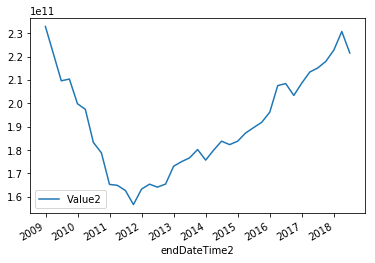

In [393]:
df_consolidated[(df_consolidated.isInstantPeriod) &
           (df_consolidated.Account=='us-gaap:Liabilities')].sort_values('endDateTime2').plot(x='endDateTime2',y='Value2')

In [388]:
df_consolidated.query('isStartEndPeriod and Days2<100').Account.value_counts()

us-gaap:ComprehensiveIncomeNetOfTaxIncludingPortionAttributableToNoncontrollingInterest                                                                    41
us-gaap:IncomeTaxExpenseBenefit                                                                                                                            41
us-gaap:EarningsPerShareBasic                                                                                                                              41
us-gaap:CostOfGoodsAndServicesSold                                                                                                                         41
us-gaap:EarningsPerShareDiluted                                                                                                                            41
us-gaap:ProfitLoss                                                                                                                                         41
us-gaap:IncomeLossFromEquityMethodInvestments       

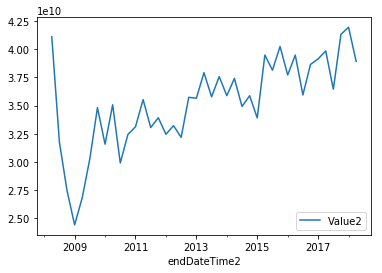

In [392]:
df_consolidated[(df_consolidated.isStartEndPeriod) &
           (df_consolidated.Account=='us-gaap:Revenues') &
           (df_consolidated.Days2<100)].sort_values('endDateTime2').plot(x='endDateTime2',y='Value2')